In [2]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install nltk
!pip install wordcloud
!pip install sklearn


[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip


In [41]:
# Step 0. Load libraries and custom modules
# Dataframes and matrices ----------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
plt.style.use('tableau-colorblind10')
# Mathematical functions -----------------------------------------------
from scipy.stats import norm
# Text processors ------------------------------------------------------
import unicodedata
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
# Preprocessing --------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# Text modeling --------------------------------------------------------
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# Model creating -------------------------------------------------------
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
# Metrics --------------------------------------------------------------
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
# Custom functions -----------------------------------------------------
from text_preprocessing import clean_stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/gitpod/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
# We'll use a collection of sentiments for text analysis as a dataset
# This dataset was published in Saif M. Mohammad and Peter Turney. (2013), 
# ``Crowdsourcing a Word-Emotion Association Lexicon.'' 
# Computational Intelligence, 29(3): 436-465.
# It's only for research and educational purposes.
# URL: http://saifmohammad.com/WebPages/lexicons.html  
nrc = pd.read_csv('../data/raw/NRC.csv', names=['word','sentiment','polarity'])
nrc = nrc.query('polarity == 1')

In [11]:
# Step 1. Load the data
# Data extracted from https://www.thetrumparchive.com
# Data case: During the 2016 US presidential election, the candidate 
# Donald Trump used twitter to communicate with potential voters. 
# The campaign was during 2015-06-17 and 2016-11-08
# We'll try to analyze these campaign tweets from iPhone and Android
# Data description
# source -> device of origin
# id_str -> unique identifier
# text -> tweet text content
# created_at -> Date of creation, not including timezone
# retweet_count -> Count of retweets (difusion)
# in_reply_to_usr_id_str -> If it's a reply, grab the user id
# favourite_count -> Count of users that liked the tweet
# is_retweet -> If the post is a retweet  
# 1.1 Open data and get a glimpse
df_raw = pd.read_csv('../data/raw/trump_tweets.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20761 entries, 0 to 20760
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   source                   20761 non-null  object 
 1   id_str                   20761 non-null  int64  
 2   text                     20761 non-null  object 
 3   created_at               20761 non-null  object 
 4   retweet_count            20761 non-null  int64  
 5   in_reply_to_user_id_str  2442 non-null   float64
 6   favorite_count           20761 non-null  int64  
 7   is_retweet               20761 non-null  bool   
dtypes: bool(1), float64(1), int64(3), object(3)
memory usage: 1.1+ MB


In [6]:
# 1.1 Sample some observations
df_raw.sample(10)

,source,id_str,text,created_at,retweet_count,in_reply_to_user_id_str,favorite_count,is_retweet
13888,Twitter Web Client,613055410669490176,"Entrepreneurs: Be tough, be smart, be personab...",2015-06-22T18:46:14Z,688,NaN,1063,False
1663,Twitter Web Client,265542606740652033,"Like Al Sharpton, @DonnyDeutsch apologized to ...",2012-11-05T19:54:25Z,101,NaN,83,False
17327,Twitter Web Client,722471042367778816,"#ICYMI: #Trump2016 closing speech in\nBuffalo,...",2016-04-19T17:04:54Z,2871,NaN,8012,False
1700,Twitter Web Client,264448271412514816,Make sure to catch @history’s season finale of...,2012-11-02T19:25:55Z,114,NaN,62,False
20480,Twitter for iPhone,831599387906301952,Great parent-teacher listening session this mo...,2017-02-14T20:21:59Z,11349,NaN,59006,False
5079,Twitter Web Client,382576725508378624,"Obama promised premiums would lower $2,500/yr ...",2013-09-24T18:46:13Z,519,NaN,108,False
7715,Twitter Web Client,315993836948168704,Always good to have @ArsenioHall back as advis...,2013-03-25T01:09:36Z,21,NaN,23,False
6135,Twitter for Android,354760250584334336,"@flyingcolours66 Thanks, it has been amazing!",2013-07-10T00:33:29Z,0,838619612.0,0,False
16778,Twitter for Android,745967990236143616,Thank you to Donald Rumsfeld for the endorseme...,2016-06-23T13:13:22Z,5908,NaN,19957,False
1795,Twitter Web Client,263280389039218690,Hurricane is good luck for Obama again- he wil...,2012-10-30T14:05:10Z,1795,NaN,481,False


In [12]:
# Step 2. Transform and wrangle the data
# 2.1 Make a copy
df_interim = df_raw.copy()

In [13]:
# 2.2 Get rid of uninformative columns
df_interim = df_interim.drop(['id_str','is_retweet','in_reply_to_user_id_str'], axis=1)

In [14]:
# 2.3 Convert columns to the right format
df_interim['created_at'] = df_interim['created_at'].astype('datetime64')
df_interim['source'] = pd.Categorical(df_interim['source'])

In [15]:
# 2.4 Filter dates for analysis
df_interim = df_interim.loc[(df_interim['created_at'] >= '2015-06-17') \
    & (df_interim['created_at'] <= '2016-11-08')]

In [27]:
# 2.5 Consider time is UTC, convert to EST
df_interim['created_at'] += pd.Timedelta(-5,uni='h')

In [28]:
# 2.5 Filter source for analysis: only care about Android and iPhone
df_interim = df_interim.loc[(df_interim['source'].str.contains('iPhone')) \
    | (df_interim['source'].str.contains('Android'))]
df_interim['source'] = df_interim['source'].cat.remove_unused_categories()

In [29]:
# 2.5 Save and create a copy for analysis
df_interim.to_csv('../data/interim/trump_tweets.csv', index=False)
df = df_interim.copy()

In [30]:
# Step 3. Perform EDA
# 3.1 Get basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3946 entries, 12072 to 18506
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   source          3946 non-null   category      
 1   text            3946 non-null   object        
 2   created_at      3946 non-null   datetime64[ns]
 3   retweet_count   3946 non-null   int64         
 4   favorite_count  3946 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(2), object(1)
memory usage: 158.0+ KB


In [31]:
# 3.2 Get a sample
df.sample(5)

,source,text,created_at,retweet_count,favorite_count
13249,Twitter for Android,"The phony Club For Growth, which asked me in w...",2015-09-06 20:11:42.999999990,1408,3300
13604,Twitter for Android,"John McCain called thousands of people ""crazie...",2015-07-19 10:15:49.999999990,2205,3194
17955,Twitter for iPhone,Join us Saturday night- for the South Carolina...,2016-02-18 20:16:03.999999990,2837,6091
17726,Twitter for iPhone,I am watching two clown announcers on @FoxNews...,2016-03-05 18:09:49.999999990,4522,13221
15396,Twitter for iPhone,#ObamacareFail https://t.co/iusXk4n9w7,2016-10-29 17:02:03.999999990,11196,20427


In [22]:
# 3.3 Describe numerical and datetime data
df.describe(datetime_is_numeric=True)

,created_at,retweet_count,favorite_count
count,3946,3946.000000,3946.000000
mean,2016-03-31 12:49:53.323872256,5839.465281,15666.982767
min,2015-06-20 01:03:04.999999995,61.000000,167.000000
25%,2015-12-20 23:19:10.500000,2013.250000,5350.000000
50%,2016-03-16 10:29:30.500000,4162.500000,11981.500000
75%,2016-07-25 14:04:26.500000,7807.250000,21527.000000
max,2016-11-07 22:21:52.999999995,168765.000000,297281.000000
std,NaN,6156.818896,14650.408743


In [32]:
# 3.4 Describe categorical data
df['source'].value_counts()

Twitter for iPhone     2099
Twitter for Android    1847
Name: source, dtype: int64

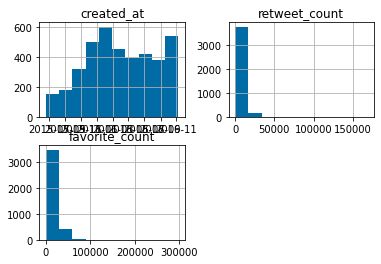

In [33]:
# 3.5 Get histograms for numerical data
df.hist()
plt.show()

In [34]:
# 3.6 Make a plot of tweets frequence rate by source
df_plot = (df
            .assign(hour=df['created_at'].dt.hour)
            .groupby(['source', 'hour'])
            .agg(count=('source', 'count'))
            .assign(rate=lambda df : df['count']/df.groupby('source')['count'].sum())
            .reset_index()
            )
df_plot

,source,hour,count,rate
0,Twitter for Android,0,89,0.048186
1,Twitter for Android,1,90,0.048728
2,Twitter for Android,2,93,0.050352
3,Twitter for Android,3,78,0.042231
4,Twitter for Android,4,49,0.026530
5,Twitter for Android,5,22,0.011911
6,Twitter for Android,6,2,0.001083
7,Twitter for Android,7,6,0.003249
8,Twitter for Android,8,1,0.000541
9,Twitter for Android,9,28,0.015160


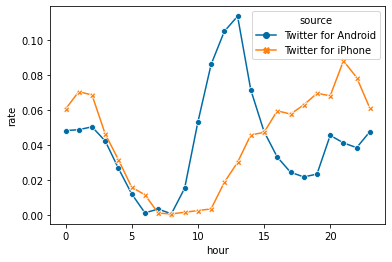

In [35]:
sns.lineplot(data=df_plot, x='hour', y='rate', hue='source', markers=True, style='source', dashes=False)
plt.show()

In [36]:
# 3.7 Get a glimpse of the most retweeted tweets
df.sort_values(by='retweet_count', ascending=False)[['text', 'retweet_count']][:10]

,text,retweet_count
16875,How long did it take your staff of 823 people ...,168765
17183,Happy #CincoDeMayo! The best taco bowls are ma...,85465
15333,MAKE AMERICA GREAT AGAIN!,59098
15758,Here is my statement. https://t.co/WAZiGoQqMQ,51891
16548,Such a great honor to be the Republican Nomine...,41616
15340,If Obama worked as hard on straightening out o...,41479
15827,For those few people knocking me for tweeting ...,40850
15756,The media and establishment want me out of the...,40772
16583,I am pleased to announce that I have chosen Go...,38782
16848,Is President Obama going to finally mention th...,38456


In [37]:
# 3.8 Get a glimpse of the most liked tweets
df.sort_values(by='favorite_count', ascending=False)[['text', 'favorite_count']][:10]


,text,favorite_count
16875,How long did it take your staff of 823 people ...,297281
16548,Such a great honor to be the Republican Nomine...,129652
15758,Here is my statement. https://t.co/WAZiGoQqMQ,120244
15781,Mike Pence won big. We should all be proud of ...,120189
17183,Happy #CincoDeMayo! The best taco bowls are ma...,119759
15333,MAKE AMERICA GREAT AGAIN!,115387
15827,For those few people knocking me for tweeting ...,107497
15756,The media and establishment want me out of the...,105680
15340,If Obama worked as hard on straightening out o...,102045
16583,I am pleased to announce that I have chosen Go...,92250


In [38]:
# 3.9 Let's get a glimpse of common words in the tweets' text
df['text'].str.split(expand=True).stack().value_counts()[:10]

the    1965
to     1369
and    1186
I      1133
in     1098
a       987
of      957
is      904
on      829
for     703
dtype: int64

In [43]:
# 3.10 Process text to extract stopwords
df['text_clean'] = df.text.str.lower()
stop_dict = stopwords.words('english')
# Necesito lambda para pasarla mas de un argumento a la función (clean_stopwords)
df['text_clean'] = df['text_clean'].apply(lambda x: clean_stopwords(x, stop_dict=stop_dict))
df['text_clean'] = df['text_clean'].str.replace(r'''['!,.]''', '', regex=True)

In [45]:
# 3.11 Extract urls
url_pat = 'https://t.co/[A-Za-z\d]+|&amp;'


In [46]:
# 3.12 Extract special characters
df['text_clean'] = df['text_clean'].str.replace(url_pat, '', regex=True)

In [47]:
# 3.13 Extract special characters
df['text_clean'] = df['text_clean'].str.replace(r'''[!.,():\-%$/'"']''', '', regex=True)

In [49]:
# 3.13 Extract numbers
df['text_clean'] = df['text_clean'].str.replace(r'[\d]+', '', regex=True)

In [50]:
# 3.14 See the results
df[['text', 'text_clean',]].sample(5)

,text,text_clean
17798,I am self funding my campaign and only work fo...,self funding campaign work you american people...
18206,Being politically correct takes too much time....,politically correct takes much time much get d...
18340,A great morning with everyone @LibertyU! Thank...,great morning everyone @libertyu thank you new...
12110,"If Hillary thinks she can unleash her husband,...",hillary thinks unleash husband terrible record...
16031,Thank you North Carolina- get out &amp; #VoteT...,thank north carolina get #votetrump #makeame...


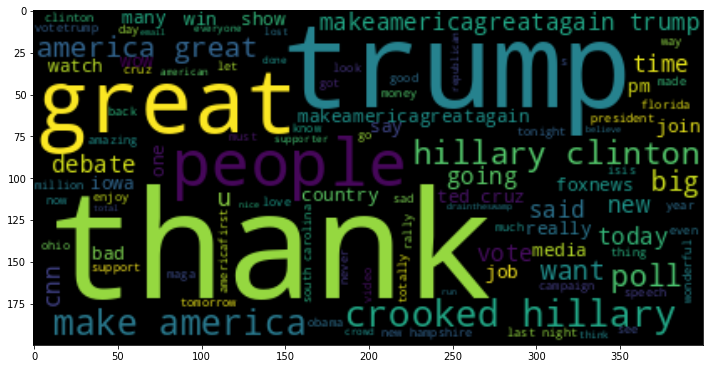

In [52]:
# 3.15 Let's see a wordcloud
text = ' '.join([i for i in df.text_clean])
wordcloud = WordCloud(max_words=100, background_color='black').generate(text)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

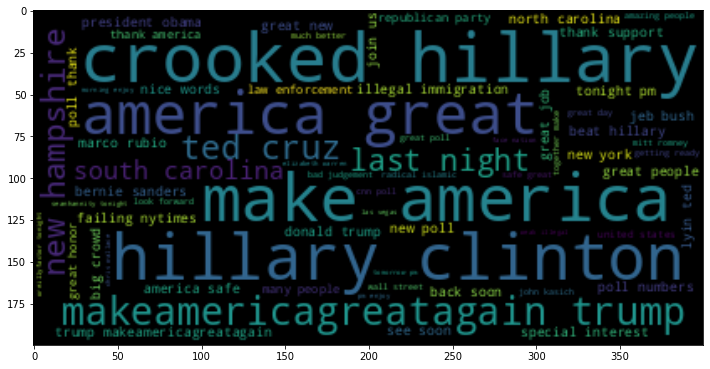

In [55]:
# Estudar 'bigramos': dos palarbas consecutivas

wordcloud_bg = WordCloud(collocation_threshold=2, collocations=True, max_words=100, background_color='black').generate(text)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud_bg, interpolation='bilinear')
plt.show()

In [57]:
# slice text, asociate each word with a feeling
df_word_split = (df
                 .drop(['text', 'created_at', 'retweet_count', 'favorite_count'], axis=1),
                 .assign(text=df['text_clean'].str.split())
                ).explode('text').drop('text_clean', axis=1).rename(columns={'text':'word'})
df_word_split                

SyntaxError: invalid syntax (3145341352.py, line 4)

In [58]:
# slice text, asociate each word with a feeling
df_word_split = (df
.drop(['text','created_at','retweet_count','favorite_count'],axis=1)
.assign(text=df['text_clean'].str.split())).explode('text').drop('text_clean',axis=1).rename(columns={'text':'word'})
df_word_split

,source,word
12072,Twitter for Android,would
12072,Twitter for Android,like
12072,Twitter for Android,wish
12072,Twitter for Android,everyone
12072,Twitter for Android,happy
...,...,...
18506,Twitter for Android,together
18506,Twitter for Android,make
18506,Twitter for Android,america
18506,Twitter for Android,great


In [59]:
# inner join: word vs sentiment
df_word_split.merge(nrc[['word', 'sentiment']], on='word', how='inner')

,source,word,sentiment
0,Twitter for Android,happy,anticipation
1,Twitter for Android,happy,joy
2,Twitter for Android,happy,positive
3,Twitter for Android,happy,trust
4,Twitter for iPhone,happy,anticipation
...,...,...,...
17547,Twitter for Android,stiff,negative
17548,Twitter for Android,embarrassment,fear
17549,Twitter for Android,embarrassment,negative
17550,Twitter for Android,embarrassment,sadness


In [60]:
df_sent = df_word_split\
    .merge(nrc[['word', 'sentiment']], on='word', how='inner')\
    .groupby(['source', 'sentiment']).agg(count=('sentiment', 'count'))\
    .reset_index().pivot_table(index=['sentiment'], columns=['source'], values='count')\
    .reset_index()\
    .rename(columns={'Twitter for Android':'Android', 'Twitter for iPhone':'iPhone'})

df_sent    


source,sentiment,Android,iPhone
0,anger,949,514
1,anticipation,986,725
2,disgust,632,307
3,fear,815,477
4,joy,743,543
5,negative,1671,925
6,positive,1963,1522
7,sadness,911,512
8,surprise,587,385
9,trust,1363,1022


In [66]:
#Frecuencias relativas | Odd ratio
df_odd_ratio = df_sent.\
assign(odd_ratio = (df_sent['Android']/(df_sent['Android'].sum()-df_sent['Android']))/(df_sent['iPhone']/(df_sent['iPhone'].sum()-df_sent['iPhone'])))

#Creamos columna con el logaritmo de odd ratio
df_odd_ratio['log_or'] = np.log(df_odd_ratio['odd_ratio'])

In [67]:
df_odd_ratio.sort_values(by='log_or', ascending=False)

source,sentiment,Android,iPhone,odd_ratio,log_or
2,disgust,632,307,1.365482,0.311508
0,anger,949,514,1.225269,0.203160
5,negative,1671,925,1.212601,0.192767
7,sadness,911,512,1.176546,0.162583
3,fear,815,477,1.124833,0.117634
8,surprise,587,385,0.994922,-0.005091
4,joy,743,543,0.885109,-0.122044
1,anticipation,986,725,0.876222,-0.132136
9,trust,1363,1022,0.851456,-0.160808
6,positive,1963,1522,0.806001,-0.215670


In [73]:
# intervalos de confianza

# std error
#df_odd_ratio['se'] = np.sqrt(1/df_odd_ratio['Android']+1/(df_odd_ratio['Android'].sum()-df_odd_ratio['Android'])+1/df_odd_ratio['iPhone'])
df_odd_ratio['se'] = np.sqrt(1/df_odd_ratio['Android'] + 1/(df_odd_ratio['Android'].sum()-df_odd_ratio['Android'])+1/df_odd_ratio['iPhone']+1/(df_odd_ratio['iPhone'].sum()-df_odd_ratio['iPhone']))

# intervalo confianza 5%
df_odd_ratio['conf_low'] = df_odd_ratio['log_or'] - norm.ppf(0.975)*df_odd_ratio['se']
df_odd_ratio['conf_high'] = df_odd_ratio['log_or'] + norm.ppf(0.975)*df_odd_ratio['se']
df_odd_ratio.sort_values(by = 'log_or', ascending = False)

source,sentiment,Android,iPhone,odd_ratio,log_or,se,conf_low,conf_hight,conf_high
2,disgust,632,307,1.365482,0.311508,0.071349,0.171666,0.451349,0.451349
0,anger,949,514,1.225269,0.203160,0.057083,0.091280,0.315041,0.315041
5,negative,1671,925,1.212601,0.192767,0.044246,0.106046,0.279489,0.279489
7,sadness,911,512,1.176546,0.162583,0.057529,0.049828,0.275338,0.275338
3,fear,815,477,1.124833,0.117634,0.059836,0.000358,0.234910,0.234910
8,surprise,587,385,0.994922,-0.005091,0.067479,-0.137347,0.127165,0.127165
4,joy,743,543,0.885109,-0.122044,0.058697,-0.237087,-0.007001,-0.007001
1,anticipation,986,725,0.876222,-0.132136,0.051560,-0.233192,-0.031081,-0.031081
9,trust,1363,1022,0.851456,-0.160808,0.044602,-0.248227,-0.073388,-0.073388
6,positive,1963,1522,0.806001,-0.215670,0.038299,-0.290735,-0.140606,-0.140606


positivos--> Android ;;;
negativos --> iPhone ;;;
Si contiene el 0, no puedo concluir ;;;

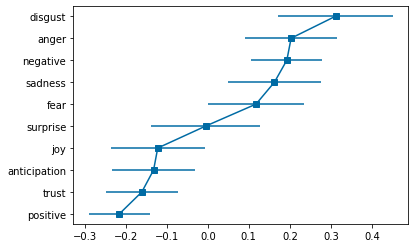

In [74]:
df_odd_ratio = df_odd_ratio.sort_values(by='log_or', ascending=True)
plt.errorbar(df_odd_ratio['log_or'], df_odd_ratio['sentiment'], marker='s', xerr=((df_odd_ratio.log_or - df_odd_ratio.conf_low), (df_odd_ratio.conf_high - df_odd_ratio.log_or)))
plt.show()